In [1]:
import pandas as pd
import os
import numpy as np
import math
import matplotlib.pyplot as plt

Optimal:


theta                                    20.000000
Irradiation (kWh-m2)                   1560.404610
Irradiation Eff. Corrected (kWh-m2)     335.486991
PV Radiation (kWh)                      546.732414
PV Count                                 15.000000
Total PV Area (m2)                       24.445020
Roof Coverage (%)                         8.436782
Name: 1, dtype: float64

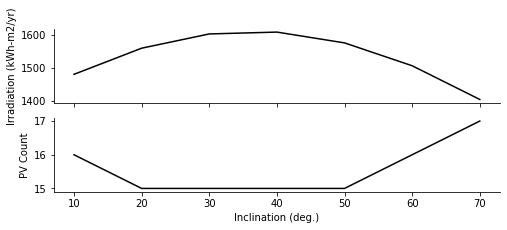

In [2]:
# Specifications
'''
PV Reference:
# SunPower® X-Series Residential Solar Panels X21-345,
# https://us.sunpower.com/sites/default/files/media-library/data-sheets/ds-x21-series-335-345-residential-solar-panels.pdf
'''
pv_width = 1.046 # [m]
pv_length = 1.558 # [m]
roof_dimensions = [[23.61,8.7],[5.29,7.66],[6.35,6.9]] # [m]
total_roof_area = sum([area[0] * area[1] for area in roof_dimensions])
pv_eff = 0.215
pv_rating = 0.250 # [kW]
site_electrical_energy = 8067 # kWh

# Analysis
df_list = []
for filename in os.listdir('irradiation_data'):
    if '.csv' in filename:
        df = pd.read_csv(f'irradiation_data/{filename}',skiprows=9)
        df['Irradiation (kWh-m2)'] = (df['Total solar rad on wall after shading (Btu/Hr-Ft2)'] * 3.154) / 1000
        df = df[['Irradiation (kWh-m2)']]
        df['theta'] = int(filename.split('_')[0])
        df_list.append(df)

df = pd.concat(df_list,ignore_index=True)
df = df.groupby('theta').sum().reset_index()
df['Irradiation Eff. Corrected (kWh-m2)'] = df['Irradiation (kWh-m2)'] * pv_eff
df['PV Radiation (kWh)'] = df['Irradiation Eff. Corrected (kWh-m2)'] * (pv_width * pv_length)
df['PV Count'] = np.ceil(site_electrical_energy / df['PV Radiation (kWh)'])
df['Total PV Area (m2)'] = df['PV Count'] * (pv_width * pv_length)
df['Roof Coverage (%)'] = (df['Total PV Area (m2)'] * 100) / total_roof_area

# Optimal setup
optimal = df[df['PV Count'] == df['PV Count'].min()].sort_values('theta').iloc[0]
print(f'Optimal:')
display(optimal)

# Plots
fig, axs = plt.subplots(2,1,figsize=(8,3),sharex=True)
df.set_index('theta')[['Irradiation (kWh-m2)']].plot(ax=axs[0],color='black')
axs[0].set_xlabel('Inclination (deg.)')
axs[0].set_ylabel('Irradiation (kWh-m2/yr)')
axs[0].legend().set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

df.set_index('theta')[['PV Count']].plot(ax=axs[1],color='black')
axs[1].set_xlabel('Inclination (deg.)')
axs[1].set_ylabel('PV Count')
axs[1].legend().set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

In [3]:
# Arrangement
rows = 2
optimal_row_length = pv_length * np.ceil(optimal['PV Count'] / rows)
hypotenuse = pv_width * rows
adjacent = math.cos(math.radians(optimal['theta'])) * hypotenuse
opposite = math.sin(math.radians(optimal['theta'])) * hypotenuse
print(f'Optimal {rows} row total length: {optimal_row_length}')
print(f'Hypotenuse: {hypotenuse}')
print(f'Adjacent: {adjacent}')
print(f'Opposite: {opposite}')

Optimal 2 row total length: 12.464
Hypotenuse: 2.092
Adjacent: 1.9658369626841206
Opposite: 0.7155061398372989
